In [1]:
# circuit construction and execution:
#   - circuit, register, classical bit, executor, simulator
from qiskit import  QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer

# Visualization: 
#   - basis amplitudes, bloch vector
from qiskit.visualization import plot_histogram, plot_bloch_multivector

# Input state initialization:
#   - initial psi
from qiskit.extensions import Initialize
# initialized state are numpy complex arrays
import numpy as np

# state vector presentation
from qiskit_textbook.tools import array_to_latex, random_state

In [2]:
# construct quantum teleportation circuit
def qtel(state):
    # circuit initialization
    psi = QuantumRegister(1,name="psi")
    alice = QuantumRegister(1,name="alice")
    bob = QuantumRegister(1,name="bob")

    crx = ClassicalRegister(1, name="crx")
    crz = ClassicalRegister(1, name="crz")
    res = ClassicalRegister(1, name="result")

    qtel_circ = QuantumCircuit(psi,alice,bob,crx,crz,res)
    
    #step 0 initialize psi
    init_gate = Initialize(state)
    init_gate.label = "init"
    qtel_circ.append(init_gate, [0])
    
    qtel_circ.barrier()

    # step 1 prepare bell state between alice and bob
    qtel_circ.h(alice)
    qtel_circ.cx(alice,bob)

    qtel_circ.barrier()

    # step 2 alice gate
    qtel_circ.cx(psi,alice)
    qtel_circ.h(psi)

    qtel_circ.barrier()

    #step 3 meaure as classical bits
    qtel_circ.measure(alice,crx)
    qtel_circ.measure(psi,crz)

    qtel_circ.barrier()
    #step 4 bob gate
    qtel_circ.x(bob).c_if(crx,1)
    qtel_circ.z(bob).c_if(crz,1)

    reverse_init = init_gate.gates_to_uncompute()
    qtel_circ.append(reverse_init,[2])
    qtel_circ.measure(bob,res)

    return qtel_circ

<IPython.core.display.Math object>

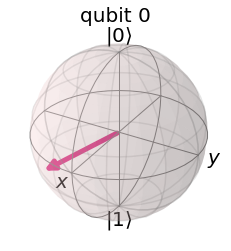

In [3]:
# state initialization
psi = random_state(1)
#viz
array_to_latex(psi, pretext="\\vert\\psi\\rangle =")
plot_bloch_multivector(psi)

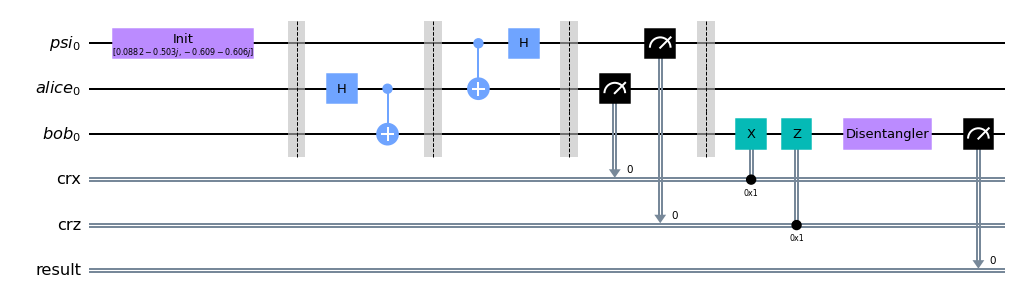

In [4]:
circ = qtel(psi)
circ.draw("mpl")

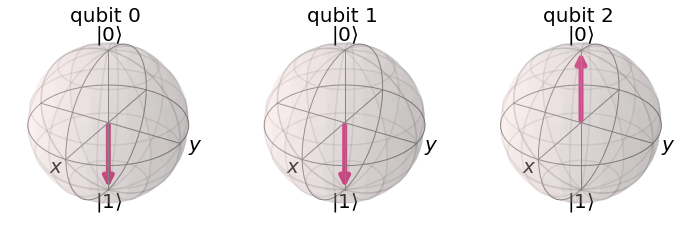

In [5]:
# set up simulator
state_sim_back = BasicAer.get_backend("statevector_simulator")
res_vetor = execute(circ, backend=state_sim_back).result().get_statevector()
plot_bloch_multivector(res_vetor)

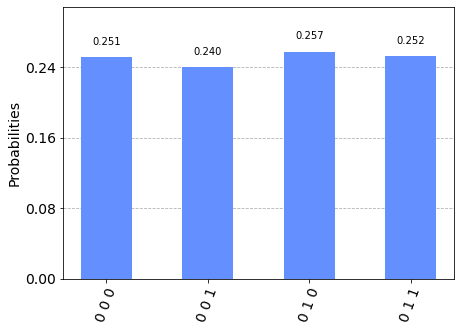

In [6]:
circ_sim_back = BasicAer.get_backend("qasm_simulator")
counts = execute(circ, backend=circ_sim_back, shots=1024).result().get_counts()
plot_histogram(counts)

## Implement circuit for Hardware
Since IBMQ currently does not support instruction after measurment, we modify the circuit such that all the measurment are at the end.

In [7]:
def modified_qtel(state):
    qc = QuantumCircuit(3,1)
    
    init_gate =Initialize(state)
    init_gate.label = "init"
    qc.append(init_gate, [0])
    
    qc.barrier()

    qc.h(1)
    qc.cx(1,2)

    qc.barrier()

    qc.cx(0,1)
    qc.h(0)

    qc.barrier()

    qc.cx(1,2)
    qc.cz(0,2)

    qc.barrier()

    reverse_init_gate = init_gate.gates_to_uncompute()
    qc.append(reverse_init_gate,[2])

    qc.measure(2,0)

    return qc

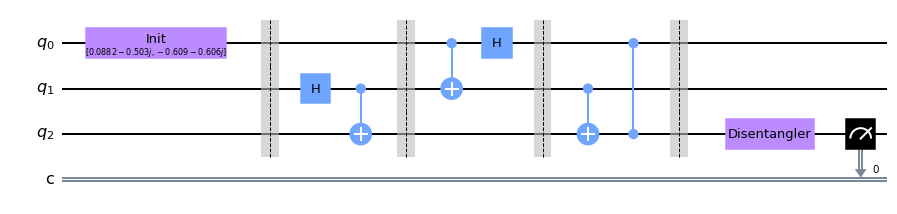

In [8]:
circ_hard = modified_qtel(psi)
circ_hard.draw("mpl")

## Run on actual hardware
activate IBMQ account locally using token

In [ ]:
from qiskit import IBMQ

In [ ]:
IBMQ.enable_account(token='')

In [ ]:
IBMQ.save_account(token='',overwrite=True)

In [ ]:
IBMQ.stored_account()

In [ ]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

In [ ]:
from qiskit.providers.ibmq import least_busy
backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                   not b.configuration().simulator and b.status().operational==True))
job_exp = execute(circ_hard, backend=backend, shots=8192)

In [ ]:
from qiskit.tools.monitor import job_monitor
job_monitor(job_exp)  # displays job status under cell

# Get the results and display them
exp_result = job_exp.result()
exp_measurement_result = exp_result.get_counts(circ_hard)
print(exp_measurement_result)
plot_histogram(exp_measurement_result)